In [121]:
# !pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

In [122]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# Model Packages
import sklearn
# import ngboost
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, classification_report
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline
cm = sns.light_palette("green", as_cmap=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load Dataset

In [123]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
print(df_train.shape)

In [124]:
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
PassengerId = df_test['PassengerId']
print(df_test.shape)

# Explore Data

I recommend [this notebook](https://github.com/AnelMusic/Kaggle_Titanic_Advanced_DataAnalysis/blob/main/Titanic_DataAnalysis_Top3.ipynb) for those who would like to get more infomation from plots.

In [125]:
display(df_train.head())
display(df_test.head())

In [126]:
print(df_train.columns)
print(df_test.columns)

In [127]:
display(df_train.isnull().mean().T)
display(df_test.isnull().mean().T)

In [128]:
df_train.Ticket.nunique()
# df_train.Ticket.unique()

In [129]:
df_train['Fare'] = round(df_train['Fare'])
print(df_train.Fare.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
sns.displot(df_train[df_train.Fare<50].Fare)

In [130]:
df_train.Age.describe()

In [131]:
print(df_train.Name.nunique())
df_train.head(5).Name.unique()

In [132]:
df_train.Embarked.unique()

In [133]:
df_train.Cabin.unique()

In [134]:
df_train.Sex.unique()

In [135]:
df_train.Fare.unique()

In [136]:
def plot_distribution(df, feature, title, bins=30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(df[feature], color='orange', bins=bins, ax=ax)
    fig.legend()
    return

def plot_kde_survivors(df, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(df[feature].loc[df["Survived"] == 1],
                shade= True, ax=ax, label='Survived').set_xlabel(feature)
    sns.kdeplot(df[feature].loc[df["Survived"] == 0],
                shade=True, ax=ax, label="Not Survived")
    fig.legend()
    return

plot_distribution(df_train, 'Age', 'Training Age Distribution')
plot_distribution(df_test, 'Age', 'Testing Age Distribution')

# Feature Engineering

I followed this regular expression tutorial to get the string in name.

[Chinese Version Tutorial](https://blog.techbridge.cc/2020/05/14/introduction-to-regular-expression/)

[English Version Tutorial](https://refrf.dev/)

[Python Library](https://docs.python.org/3/library/re.html)

I also referred to this [Kaggle notebook](https://www.kaggle.com/code/gauravduttakiit/regular-expressions/notebook) for the following two tables:

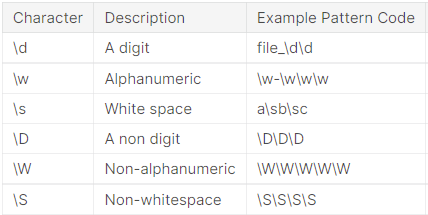
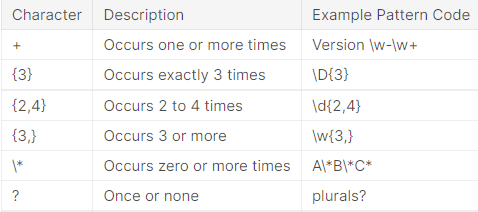

For the feature analysis before engineering, it's interesting to see [this article](https://www.shiftcomm.com/insights/never-let-go-titanic-survival-101/).

In [137]:
# Note: Name format 'Braund, Mr. Owen Harris'
def get_title(name):
    title_search = re.search(', ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    else:
        return 'None'

def feature_construction(df):
    # Name Length
    df['name_length'] = df['Name'].apply(len)
    # Title
    df['name_title'] = df['Name'].apply(get_title)
    df['name_title'] = df['name_title'].replace(['Lady', 'Mlle', 'Ms'], 'Miss')
    df['name_title'] = df['name_title'].replace(['Mme', 'Dona'], 'Mrs')
    df['name_title'] = df['name_title'].replace(['Don', 'Sir'], 'Mr')
    df['Age'] = np.where((df['name_title']=='Master')&(df['Age'].isna()), 14, df['Age']) # Special Treatment
    df['name_title'] = df['name_title'].replace(['Dr','Capt', 'Col', 'Major', 'Jonkheer', 'Master', 'Rev'], 'Special')
    # Cabin
    df['has_cabin'] = np.where(df["Cabin"].isna(), 0, 1)
    df['cabin_category'] = np.where(df["Cabin"].isna(), 'nan', df["Cabin"].str[:1])
    # Family
    df['family'] = df['SibSp'] + df['Parch'] + 1
    df['is_alone'] = np.where(df.family==1, 1, 0)
    return df

# Feature Construction
df_train = feature_construction(df_train)
df_test = feature_construction(df_test)

In [138]:
# Impute Data

# Impute Fare by group mean
temp_cols = ['PassengerId', 'Fare', 'Pclass']
temp = pd.concat([df_train[temp_cols], df_test[temp_cols]], ignore_index=True)
temp['Fare'] = temp.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
df_train = pd.merge(df_train.drop(columns=['Fare']), temp[['PassengerId', 'Fare']], how='left', on=['PassengerId'])
df_test = pd.merge(df_test.drop(columns=['Fare']), temp[['PassengerId', 'Fare']], how='left', on=['PassengerId'])

# Impute Embarked
df_train['Embarked'] = df_train['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

# Impute Age by group mean
temp_cols = ['PassengerId', 'Age', 'Sex', 'name_title']
temp = pd.concat([df_train[temp_cols], df_test[temp_cols]], ignore_index=True)
temp['Age'] = temp.groupby(['Sex', 'name_title'])['Age'].transform(lambda x: x.fillna(x.median()))
df_train = pd.merge(df_train.drop(columns=['Age']), temp[['PassengerId', 'Age']], how='left', on=['PassengerId'])
df_test = pd.merge(df_test.drop(columns=['Age']), temp[['PassengerId', 'Age']], how='left', on=['PassengerId'])

In [139]:
# Mapping
def mapping(df):
    # Age
    bins_1 = [0, 14, 28, 36, 50, 64, 100]
    df['age_cat'] = pd.cut(df['Age'], bins = bins_1, labels=[0, 1, 2, 3, 4, 5]).astype(str)
    # Fare
    bins_2 = [0, 8.1, 15.1, 30.1, 50.1, 100, 600]
    df['fare_cat'] = pd.cut(df['Fare'], bins = bins_2, labels=[0, 1, 2, 3, 4, 5]).astype(str)
    # Sex
    df['Sex'] = np.where(df.Sex == 'female', 1, 0)
    return df

# Round Age and Fare
df_train['Age'] = round(df_train['Age'])
df_test['Age'] = round(df_test['Age'])

df_train['Fare'] = round(df_train['Fare'])
df_test['Fare'] = round(df_test['Fare'])
    
# Mapping
df_train = mapping(df_train)
df_test = mapping(df_test)

In [146]:
plot_kde_survivors(df_train, 'Age', 'Survivor Age Plot')
plot_kde_survivors(df_train, 'Sex', 'Survivor Sex Plot')
plot_kde_survivors(df_train, 'Fare', 'Survivor Fare Plot')

In [141]:
# Drop Columns
dropped_cols = ['PassengerId', 'Name', 'Cabin', 'Ticket', 'SibSp', 'Parch']
df_train = df_train.drop(columns=dropped_cols)
df_test = df_test.drop(columns=dropped_cols)

# Catboost Prediction

See [this notebook](https://www.kaggle.com/code/odaymourad/learn-overfitting-and-underfitting-79-4-score) for parameter tuning.

In [142]:
y_label = 'Survived'
cat_cols = ['Pclass', 'Sex', 'Embarked', 'name_title', 'has_cabin', 'cabin_category', 'age_cat', 'fare_cat', 'is_alone']
num_cols = ['family', 'Age', 'Fare', 'name_length']
features = cat_cols + num_cols

X_train = df_train[cat_cols+num_cols]
y_train = df_train[y_label]
X_test = df_test[cat_cols+num_cols]

In [143]:
X_test.info()

In [169]:
def run_catboost(train_X, train_y, test_X):
    cv = KFold(n_splits=5, shuffle=True)

    model = CatBoostClassifier(random_state = 42,
                               # iterations = 500,
                               n_estimators = 10,
                               verbose = 100,
                               cat_features =  range(len(cat_cols)),
                               early_stopping_rounds = 50,
                               learning_rate = 0.01,
                               grow_policy = 'Lossguide',
                               auto_class_weights = 'Balanced')

    params = {'depth': [4],
              'num_leaves' : [8],
              # 'n_estimators': [4],
              'loss_function': ['Logloss']} #'CrossEntropy'
    
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1_micro', cv=cv)
    grid.fit(train_X, train_y)
    
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
    print("\n The best score of the best_estimator", grid.best_estimator_.best_score_)
    print("\n The best score across ALL searched params:\n", grid.best_score_)
    print("\n The best parameters across ALL searched params:\n", grid.best_params_)
    
    pred_train_y = grid.predict(train_X)
    pred_test_y = grid.predict(test_X)
    return pred_train_y, pred_test_y, grid.best_estimator_

In [170]:
# Training CatBoost
pred_train_catboost, pred_test_catboost, model_catboost = run_catboost(X_train, y_train, X_test)
print("CatBoost Training Completed...")

# Feature Importance

In [171]:
# define predictor and response variables
train_pool = Pool(X_train, y_train, feature_names = features, cat_features =  range(len(cat_cols)))

model_test = CatBoostClassifier(random_state = 42,
                                # iterations = 500,
                                verbose = 200,
                                depth = 4,
                                num_leaves = 8,
                                n_estimators = 20,
                                loss_function = 'Logloss',
                                cat_features =  range(len(cat_cols)),
                                early_stopping_rounds = 50,
                                learning_rate = 0.01,
                                grow_policy = 'Lossguide',
                                #auto_class_weights = 'Balanced'
                               )

summary = model_test.select_features(train_pool,
                                     features_for_select=f'0-{len(features)-1}',
                                     num_features_to_select=10,
                                     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                     shap_calc_type=EShapCalcType.Regular,
                                     train_final_model=True,
                                     # plot=True
                                    )
summary['selected_features_names']

# Evaluation and Submission


The evaluation method refers [this notebook](https://www.kaggle.com/code/kevrchen/catboost-gridsearchcv-feature-engineering/notebook).

In [172]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_train, pred_train_catboost, normalize=True)
print(classification_report(y_train, pred_train_catboost))

In [173]:
submission = pd.DataFrame({'PassengerId': PassengerId,
                           'Survived': pred_test_catboost})

submission.to_csv("submission.csv", index=False)